In [1]:
import numpy
import cupy as np
import chainer.cuda

/home/timanishi/.pyenv/versions/3.7.8/lib/python3.7/site-packages/chainer/_environment_check.py:91: UserWarning: 
--------------------------------------------------------------------------------
Multiple installations of CuPy package has been detected.
You should select only one package from from ['cupy-cuda102', 'cupy-cuda101', 'cupy-cuda100', 'cupy-cuda92', 'cupy-cuda91', 'cupy-cuda90', 'cupy-cuda80', 'cupy'].
Follow these steps to resolve this issue:
  1. `pip list` to list CuPy packages installed
  2. `pip uninstall <package name>` to uninstall all CuPy packages
  3. `pip install <package name>` to install the proper one
--------------------------------------------------------------------------------

  '''.format(name=name, pkgs=pkgs))


## ディープニューラルネットワークスクラッチ
前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。

名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。

#### 層などのクラス化
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

手を加える箇所

- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

《サンプルコード1》

ScratchDeepNeuralNetrowkClassifierのfitメソッド内
```
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数
optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()
```

《サンプルコード2》

イテレーションごとのフォワード
```
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)
```

《サンプルコード3》

イテレーションごとのバックワード
```
dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
```

### 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。

以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

《雛形》
```
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        pass
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        pass
        return A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        pass
        # 更新
        self = self.optimizer.update(self)
        return dZ
```

In [2]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        out = np.dot(X, self.W) + self.b
        
        return out

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        batch_size = dA.shape[0]
        dX = np.dot(dA, self.W.T)
        self.dW = np.dot(self.X.T, dA) / batch_size
        self.db = np.sum(dA, axis=0) / batch_size
        self = self.optimizer.update(self)
        
        return dX


- FCクラスの__init__,forward,backwardメソッドを更新

### 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。

前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

《雛形》
```
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        pass
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        pass
        return B
```

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)
        return B

- SimpleInitializerクラスのW, Bメソッドを更新

### 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。

最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

雛形
```
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
```

In [4]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.b -= self.lr * layer.db

### 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。

ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

#### 発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

In [5]:
class Sigmoid():
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        out = 1 / (1 + np.exp(-X))
        self.out = out
        
        return out
        
    def backward(self, dout):
        dX = dout*(1.0 - self.out)*self.out
        
        return dX


class Tanh():
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        out = np.tanh(X)
        self.out = out
        
        return out
    
    def backward(self, dout):
        dX = dout*(1 - self.out**2)
        
        return dX

    
class Softmax():
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def _softmax(self, X):
        X = X - np.max(X, axis=-1, keepdims=True)
        y = np.exp(X) / np.sum(np.exp(X), axis=-1, keepdims=True)
        
        return y
    
    def _cross_entropy_error(self, y, t):
        batch_size = y.shape[0]
        
        return -np.sum(t * np.log(y + 1e-7)) / batch_size
    
    def forward(self, X, t):
        self.t = t
        self.y = self._softmax(X)
        self.loss = self._cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dX = (self.y - self.t) / batch_size
        
        return dX

### 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。

ReLUは以下の数式です。
$$
f(x)=ReLU(x)=\begin{cases}x \quad x \geqq 0 \\
                0 \quad x < 0 \\
                \end{cases}
$$
$x$ : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)

一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。
$$
\frac{\partial f(x)}{\partial x}=\begin{cases}1\space if \quad x > 0 \\
                0\space if \quad x \leqq 0 \\
                \end{cases}
$$

数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。

フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [6]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

### 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成してください。

#### Xavierの初期値
Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。
$$
\sigma=\frac{1}{\sqrt{n}}
$$
$n$ : 前の層のノード数

《論文》

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

#### Heの初期値
Heの初期値における標準偏差 $\sigma$ は次の式で求められます。
$$
\sigma=\sqrt{\frac{2}{n}}
$$
$n$ : 前の層のノード数

《論文》

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [7]:
class XavierInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B


class HeInitializer:
    def __init__(self):
        self.sigma = None
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

### 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。

まず、これまで使ってきたSGDを確認します。
$$
W_i'=W_i-\alpha E(\frac{\partial L}{\partial W_i}) \\
B_i'=B_i-\alpha E(\frac{\partial L}{\partial B_i})
$$
$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配

$E()$ : ミニバッチ方向にベクトルの平均を計算

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$$
H_i'=H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i}) \\
W_i'=W_i-\alpha\frac{1}{\sqrt{H_i'}}E(\frac{\partial L}{\partial W_i})
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H_i^{\prime}$ : 更新した $H_i$

《論文》
[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

In [8]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h_W = None
        self.h_b = None
    def update(self, layer):
        if (self.h_W is None) and (self.h_b is None):
            self.h_W = 0
            self.h_b = 0
        
        self.h_W += (layer.dW ** 2).sum()
        self.h_b += (layer.db ** 2).sum()
        layer.W -= self.lr * layer.dW / (np.sqrt(self.h_W) + 1e-7)
        layer.b -= self.lr * layer.db / (np.sqrt(self.h_b) + 1e-7)

### 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [9]:
from collections import OrderedDict

class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr, verbose=True, batch_size=20, max_iter=3):
        self.verbose = verbose
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.list_train_loss = []
        self.list_test_loss = []
        # レイヤの生成
        initializer = XavierInitializer()
        optimizer = SGD(lr=lr)
        self.layers = OrderedDict()
        self.layers["FC1"] = FC(784, 100, initializer, optimizer)
        self.layers["tanh1"] = Tanh()
        self.layers["FC2"] = FC(100, 50, initializer, optimizer)
        self.layers["tanh2"] = Tanh()
        self.layers["FC3"] = FC(50, 10, initializer, optimizer)
        self.lastLayer = Softmax()
    
    def fit(self, X, y, X_val=None, y_val=None):
        flg_test = 0
        if (X_val is not None) and (y_val is not None):
            flg_test = 1

        # 1エポックの繰り返し数
        iter_num = int(len(X) / self.batch_size)
            
        # エポックを複数回繰り返す
        for i_ in range(self.max_iter):
            # 損失計算用
            tmp_list_loss_train = []

            # 1エポック
            for j_ in range(iter_num):
                batch_mask = np.random.choice(X.shape[0], self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                
                self._gradient(X_batch, y_batch)
                            
                tmp_list_loss_train.append(self._loss(X_batch, y_batch))
                if self.verbose:
                    #verboseをTrueにした際は学習過程などを出力する
                    print(loss_train)
        
            # 損失をインスタンス領域に設定
            self.list_train_loss.append(sum(tmp_list_loss_train)/len(tmp_list_loss_train))
            if flg_test == 1:
                loss_test = self._loss(X_val, y_val)
                self.list_test_loss.append(loss_test)
    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():
            X = layer.forward(X)
            
        pred = np.argmax(X, axis=1)
        
        return pred
    
    def _loss(self, X, t):
        for layer in self.layers.values():
            X = layer.forward(X)

        return self.lastLayer.forward(X, t)

    def _gradient(self, X, t):
        self._loss(X, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
                    
        return

### 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [10]:
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# ラベルをone-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# cupy用
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)


Using TensorFlow backend.


In [11]:
nn = ScratchDeepNeuralNetrowkClassifier(lr=0.1, verbose=False, batch_size=20, max_iter=5)
nn.fit(X_train, y_train, X_val, y_val)

In [12]:
y_val = np.argmax(y_val, axis=1)

正答率:0.9236666666666666


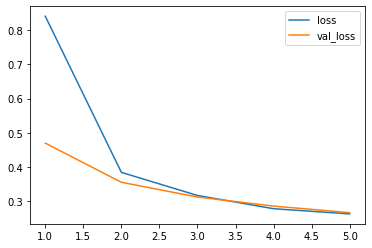

In [13]:
y_pred = nn.predict(X_val)
# cupy用
y_pred = chainer.cuda.to_cpu(y_pred)
y_val = chainer.cuda.to_cpu(y_val)

accuracy = accuracy_score(y_pred, y_val)
print("正答率:{}".format(accuracy))

x = numpy.arange(1, len(nn.list_train_loss)+1)
plt.plot(x, nn.list_train_loss, label="loss")
plt.plot(x, nn.list_test_loss, label="val_loss")
plt.legend()
plt.show()

層の数、大きさを変えて実施してみる。
- 7層
- 活性化関数：1~3層目；ReLU、4層目；tanh、5,6層目；sigmoid
- 最適化関数：AdaGrad
- 重みの初期化：He

In [14]:
from collections import OrderedDict
from copy import deepcopy

class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr, verbose=True, batch_size=20, max_iter=3):
        self.verbose = verbose
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.list_train_loss = []
        self.list_test_loss = []
        # レイヤの生成
        initializer = HeInitializer()
        optimizer = AdaGrad(lr=lr)
        self.layers = OrderedDict()
        self.layers["FC1"] = FC(784, 500, initializer, deepcopy(optimizer))
        self.layers["ReLU1"] = Relu()
        self.layers["FC2"] = FC(500, 400, initializer, deepcopy(optimizer))
        self.layers["ReLU2"] = Relu()
        self.layers["FC3"] = FC(400, 300, initializer, deepcopy(optimizer))
        self.layers["ReLU3"] = Relu()
        self.layers["FC4"] = FC(300, 200, initializer, deepcopy(optimizer))
        self.layers["tanh1"] = Tanh()
        self.layers["FC5"] = FC(200, 100, initializer, deepcopy(optimizer))
        self.layers["sigmoid1"] = Sigmoid()
        self.layers["FC6"] = FC(100, 50, initializer, deepcopy(optimizer))
        self.layers["sigmoid2"] = Sigmoid()
        self.layers["FC7"] = FC(50, 10, initializer, deepcopy(optimizer))
        self.lastLayer = Softmax()
    
    def fit(self, X, y, X_val=None, y_val=None):
        flg_test = 0
        if (X_val is not None) and (y_val is not None):
            flg_test = 1

        # 1エポックの繰り返し数
        iter_num = int(len(X) / self.batch_size)
                        
        # エポックを複数回繰り返す
        for i_ in range(self.max_iter):
            # 損失計算用
            tmp_list_loss_train = []

            # 1エポック
            for j_ in range(iter_num):
                batch_mask = np.random.choice(X.shape[0], self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                
                self._gradient(X_batch, y_batch)
                            
                tmp_list_loss_train.append(self._loss(X_batch, y_batch))
                if self.verbose:
                    #verboseをTrueにした際は学習過程などを出力する
                    print(loss_train)
        
            # 損失をインスタンス領域に設定
            self.list_train_loss.append(sum(tmp_list_loss_train)/len(tmp_list_loss_train))
            if flg_test == 1:
                loss_test = self._loss(X_val, y_val)
                self.list_test_loss.append(loss_test)
    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():
            X = layer.forward(X)
            
        pred = np.argmax(X, axis=1)
        
        return pred
    
    def _loss(self, X, t):
        for layer in self.layers.values():
            X = layer.forward(X)

        return self.lastLayer.forward(X, t)

    def _gradient(self, X, t):
        self._loss(X, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
                    
        return

正答率:0.9106666666666666


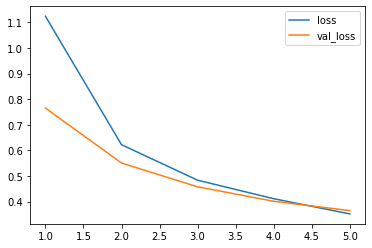

In [15]:
# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# ラベルをone-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# cupy用
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

nn = ScratchDeepNeuralNetrowkClassifier(lr=0.1, verbose=False, batch_size=20, max_iter=5)
nn.fit(X_train, y_train, X_val, y_val)

y_val = np.argmax(y_val, axis=1)

y_pred = nn.predict(X_val)
# cupy用
y_pred = chainer.cuda.to_cpu(y_pred)
y_val = chainer.cuda.to_cpu(y_val)

accuracy = accuracy_score(y_pred, y_val)
print("正答率:{}".format(accuracy))

x = numpy.arange(1, len(nn.list_train_loss)+1)
plt.plot(x, nn.list_train_loss, label="loss")
plt.plot(x, nn.list_test_loss, label="val_loss")
plt.legend()
plt.show()

単純に層を増やせば性能のいいモデルが得られるというわけではなさそうだ。
性能を上げるためにどのようにモデルを構築すればよいか、ネットで調査してみる。

[参考]
このノートブックを全実行したときの所要時間だが、CPU,GPUの動作を比較すると以下のとおりであった。
- CPU : 6分02秒
- GPU(GeForce GTX 1070(8GB)) : 2分38秒

GPUの使用率は60%あたりを推移していたが、cupyで取得していた領域は800MBほど。ノートブックはカーネルを落とすか再起動しないとGPUメモリが開放されないので注意する。